# Reproduce Allen smFISH results with Starfish

This notebook walks through a work flow that reproduces the smFISH result for one field of view using the starfish package.

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os

from starfish import data
from starfish.types import Indices

Load the Stack object, which while not well-named right now, should be thought of as an access point to an "ImageDataSet". In practice, we expect the Stack object or something similar to it to be an access point for _multiple_ fields of view. In practice, the thing we talk about as a "TileSet" is the `Stack.image` object. The data are currently stored in-memory in a `numpy.ndarray`, and that is where most of our operations are done.

The numpy array can be accessed through Stack.image.numpy\_array (public method, read only) or Stack.image.\_data (read and write)

We're ready now to load the experiment into starfish (This experiment is big, it takes a few minutes):

In [129]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.allen_smFISH(use_test_data=use_test_data)
primary_image = experiment.fov().primary_image

100%|██████████| 102/102 [00:04<00:00, 24.30it/s]


In [130]:
experiment.codebook

<xarray.Codebook (target: 3, c: 3, r: 1)>
array([[[1],
        [0],
        [0]],

       [[0],
        [1],
        [0]],

       [[0],
        [0],
        [1]]], dtype=uint8)
Coordinates:
  * target   (target) object 'Nmnt' 'Ptprt' 'Nxph2'
  * c        (c) int64 0 1 2
  * r        (r) int64 0

All of our implemented operations leverage the `Stack.image.apply` method to apply a single function over each of the tiles or volumes in the FOV, depending on whether the method accepts a 2d or 3d array. Below, we're clipping each image independently at the 10th percentile. I've placed the imports next to the methods so that you can easily locate the code, should you want to look under the hood and understand what parameters have been chosen.

The verbose flag for our apply loops could use a bit more refinement. We should be able to tell it how many images it needs to process from looking at the image stack, but for now it's dumb so just reports the number of tiles or volumes it's processed. This FOV has 102 images over 3 volumes.

This data is quite large (2.6 GB in memory) so we're going to run in-place to avoid exploding memory usage

In [131]:
from starfish.image import Filter
clip = Filter.Clip(p_min=10, p_max=100)
clip.run(primary_image, verbose=True, in_place=True)

102it [00:13,  6.35it/s]


<starfish.ImageStack (r: 1, c: 3, z: 34, y: 2048, x: 2048)>

If you ever want to visualize the image in the notebook, we've added a widget to do that. The first parameter is an indices dict that specifies which imaging round, channel, z-slice you want to view. The result is a pageable visualization across that arbitrary set of slices. Below I'm visualizing the first channel, which the codebook indicates is Nmnt.

The plot uses `rescale` to expand the dynamic range of the data to cover `[0, 1]`. 

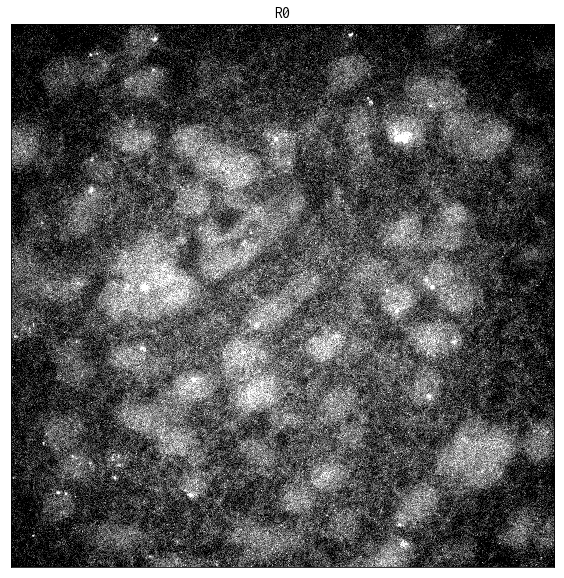

In [132]:
_ = primary_image.show_stack({Indices.CH.value: 0, Indices.Z.value: 17}, rescale=True)

In [133]:
bandpass = Filter.Bandpass(lshort=0.5, llong=7, threshold=None, truncate=4)
bandpass.run(primary_image, verbose=True, in_place=True)

102it [00:29,  3.45it/s]


<starfish.ImageStack (r: 1, c: 3, z: 34, y: 2048, x: 2048)>

To see the image, one needs to make the image quite big, but there is definitely signal present. You might need to clean your monitor to differentiate the spots from dust specs. 

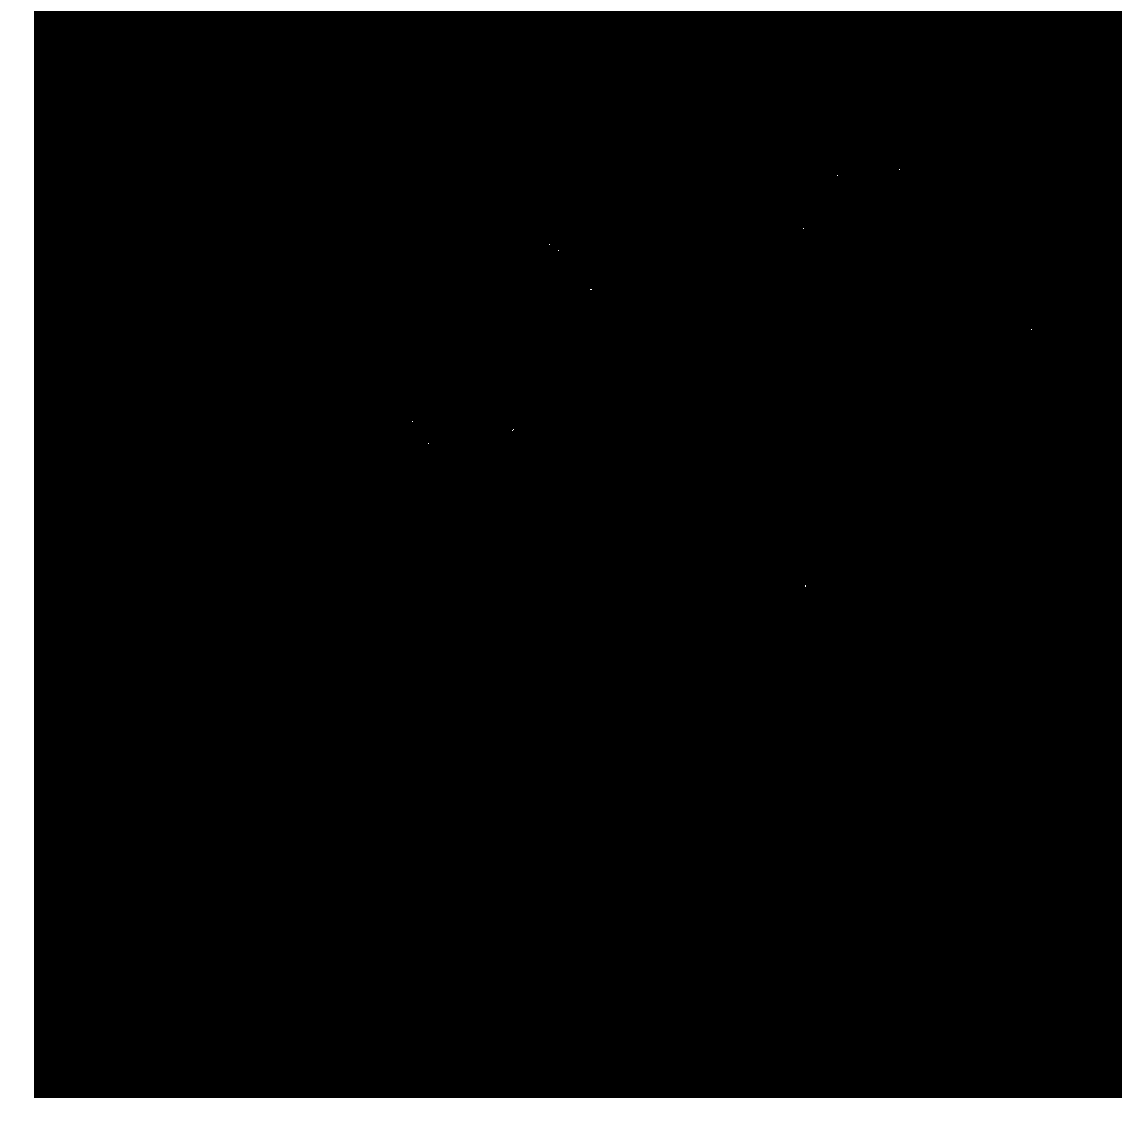

In [135]:
from showit import image
image(primary_image.get_slice({Indices.CH.value: 0, Indices.Z.value: 17})[0][0, :, :], size=20, clim=(0, 0.004))

For bandpass, there's a point where things get weird, at `c == 0; z <= 14`. In that range the images look mostly like noise. However, _above_ that, they look great + background subtracted! The later stages of the pipeline appear robust to this, though, as no spots are called for the noisy sections.

In [136]:
# I wasn't sure if this clipping was supposed to be by volume or tile. I've done tile here, but it can be switched
clip = Filter.Clip(p_min=10, p_max=100, is_volume=False)
clip.run(primary_image, verbose=True, in_place=True)

102it [00:12,  5.37it/s]


<starfish.ImageStack (r: 1, c: 3, z: 34, y: 2048, x: 2048)>

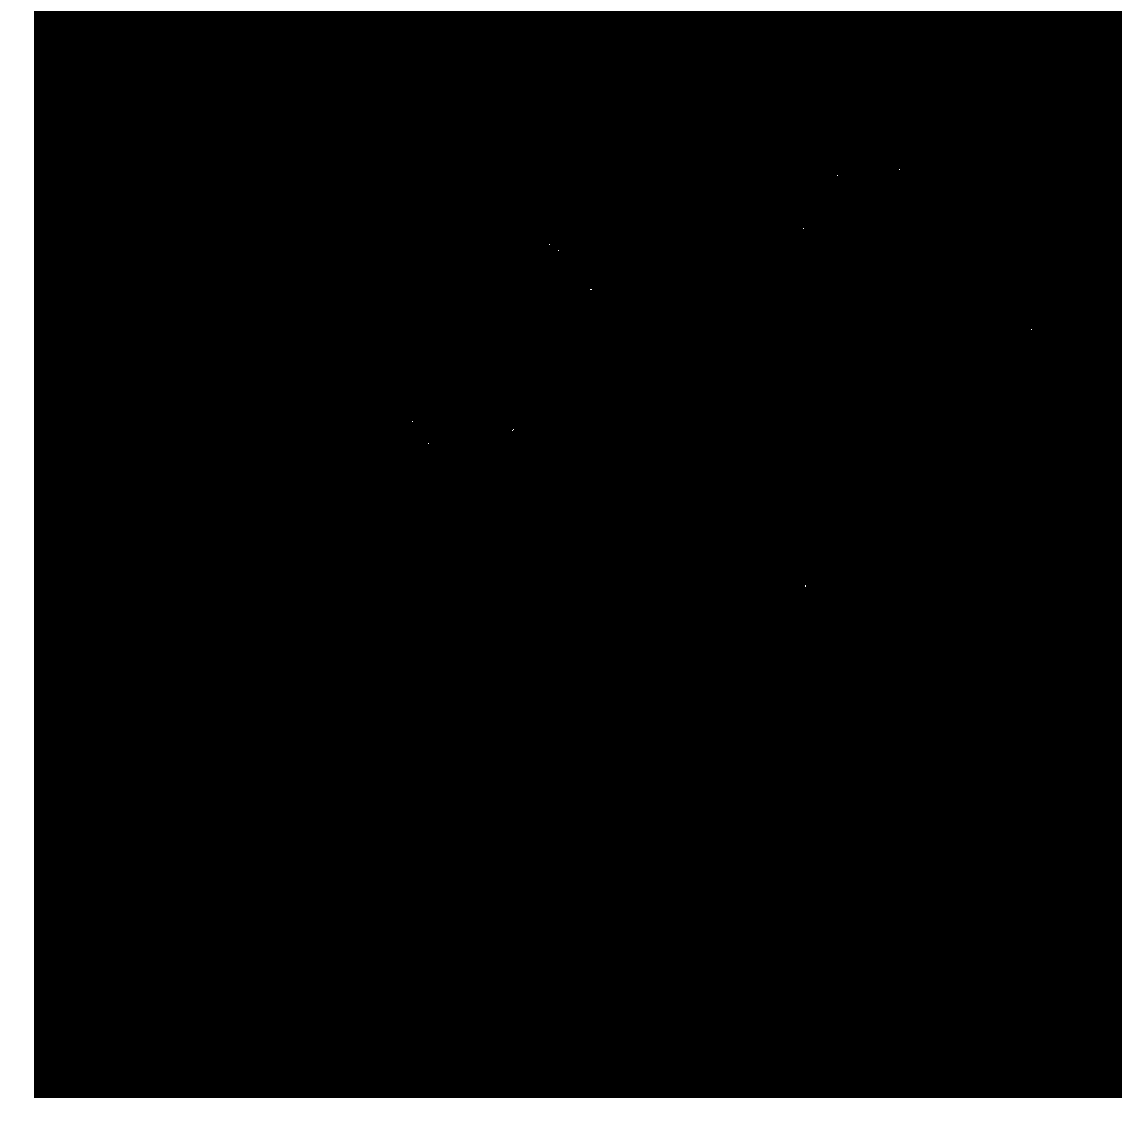

In [137]:
from showit import image
image(primary_image.get_slice({Indices.CH.value: 0, Indices.Z.value: 17})[0][0, :, :], size=20, clim=(0, 0.004))

In [140]:
sigma=(1, 0, 0)  # filter only in z, do nothing in x, y
glp = Filter.GaussianLowPass(sigma=sigma, is_volume=True)
glp.run(primary_image, in_place=True, verbose=True)

3it [00:25, 10.65s/it]


Below, because spot finding is so slow when single-plex, we'll pilot this on a max projection to show that the parameters work. Here's what trackpy.locate, which we wrap, produces for a z-projection of channel 1. To do use our plotting methods on z-projections we have to expose some of the starfish internals, which will be improved upon.

Below spot finding is on the _volumes_ for each channel. This will take about `11m30s`

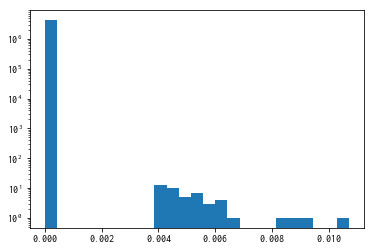

In [134]:
plt.hist(np.ravel(primary_image.get_slice({Indices.CH.value: 0, Indices.Z.value: 17})[0]), bins=25, log=True);

In [141]:
# if max radius is 3, and mean intensity is about 0.006, and we can expect spots to have around pi*r^2 integrated intensity... 
# try half-maximal radius * mean intensity
(np.pi * 1.5 ** 2) * 0.006

0.042411500823462206

Try 0.003 min_mass to start, work from there. 

In [142]:
from starfish.spots import SpotFinder

# I've guessed at these parameters from the allen_smFISH code, but you might want to tweak these a bit.
# as you can see, this function takes a while. It will be great to parallelize this. That's also coming,
# although we haven't figured out where it fits in the priority list.
kwargs = dict(
    spot_diameter=3, # must be odd integer
    min_mass=0.003,
    max_size=3,  # this is max _radius_
    separation=5,
    noise_size=0.65,  # this is not used because preprocess is False
    preprocess=False,
    percentile=10,  # this is irrelevant when min_mass, spot_diameter, and max_size are set properly
    verbose=True,
    is_volume=True,
)
lmpf = SpotFinder.LocalMaxPeakFinder(**kwargs)
spot_attributes = lmpf.run(primary_image)

In [143]:
decoded = experiment.codebook.decode_per_round_max(spot_attributes)

Count the number of spots detected in each channel

In [144]:
spot_attributes.groupby('c').apply(lambda x: np.sum(x > 0))

<xarray.IntensityTable (c: 3)>
array([74, 66, 17])
Coordinates:
  * c        (c) int64 0 1 2

Display the detected spots across a max projection of channels, rounds, and z, then color by gene type. Since this workflow ran in-place, the raw data would need to be reloaded to check against it. This is possible, but would require a workstation to keep both in-memory. Below, the spots are projected against the filtered data. You will need to squint to see them. Sorry.

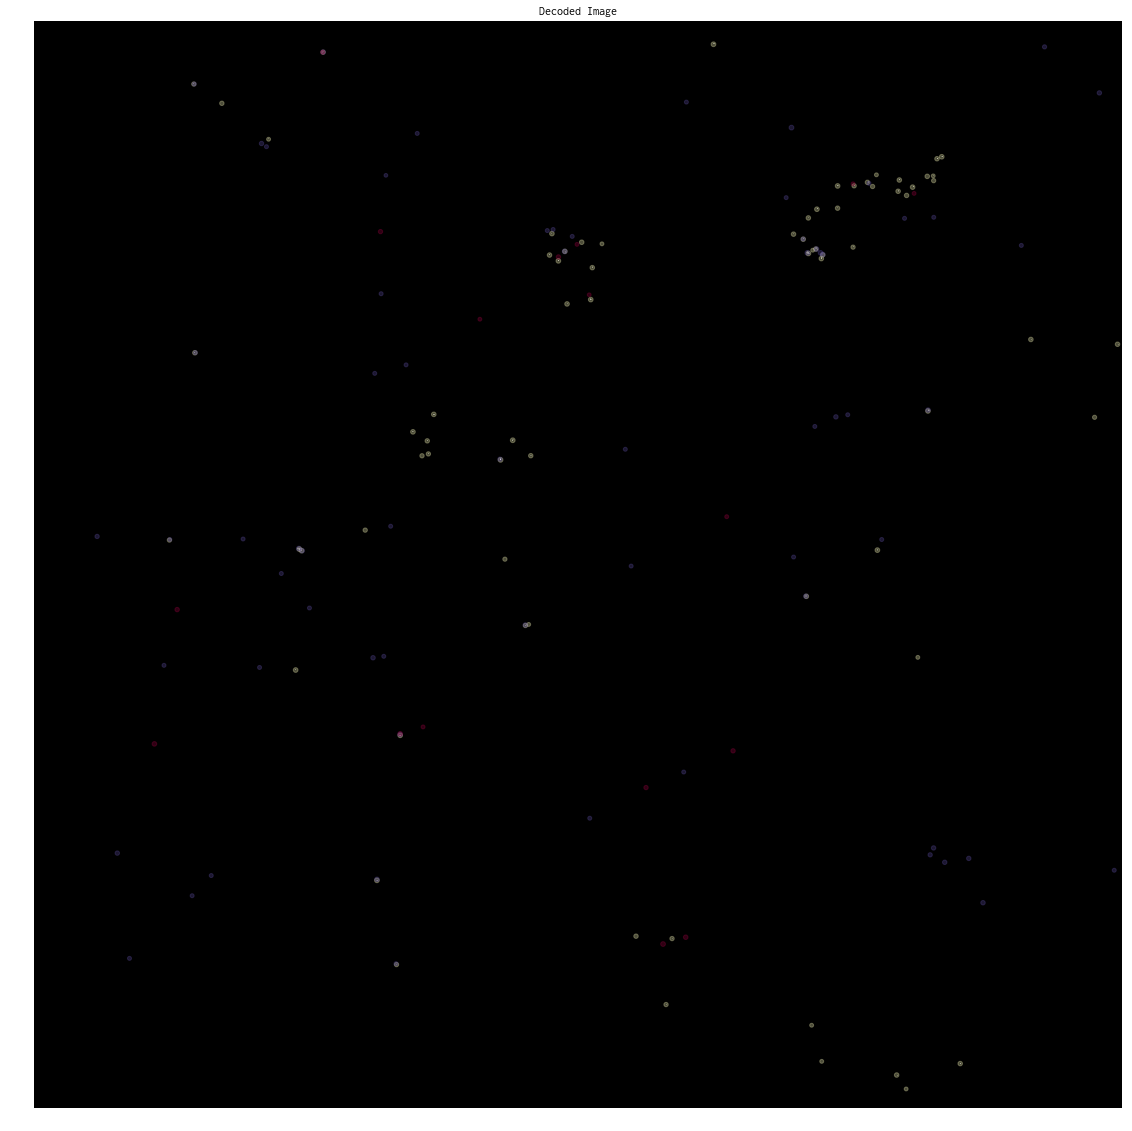

In [151]:
import starfish.plot

projection = primary_image.max_proj(Indices.Z, Indices.ROUND)

# make the radius bigger to be clearer
decoded['radius'] *= 4

f, ax = plt.subplots(figsize=(20, 20))
starfish.plot.decoded_spots(decoded, background_image=projection[0], ax=ax, spots_kwargs={'alpha': 0.3, 'cmap': plt.cm.Spectral})